

> Task 3: Customer Segmentation Using RFM Analysis



In [5]:
import pandas as pd

file_path = '/content/drive/My Drive/online_retail_II.csv'
df = pd.read_csv(file_path)
display(df.head())


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Cleaing Data

In [15]:
df = df.dropna(subset=["Customer ID"])
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]


In [17]:
# Create Total Sales column
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [22]:
import pandas as pd
# Convert 'InvoiceDate' to datetime objects
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

RFM metrics

In [26]:
import datetime as dt
snapshot_date = df["InvoiceDate"].max() + dt.timedelta(days=1)


In [29]:
# Group by customer
rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days, # Recency
    "Invoice": "count",                                    # Frequency
    "TotalPrice": "sum"                                      # Monetary
})

# Rename columns
rfm.rename(columns={"InvoiceDate": "Recency",
                    "Invoice": "Frequency",
                    "TotalPrice": "Monetary"}, inplace=True)

Scoring RFM

In [30]:
# Assigning scores from 1–5 (higher = better).
# Recency: lower is better, so reverse scoring
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)

# Frequency & Monetary: higher is better
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5]).astype(int)

# Combine into single RFM Score
rfm["RFM_Segment"] = rfm["R_Score"].map(str) + rfm["F_Score"].map(str) + rfm["M_Score"].map(str)
rfm["RFM_Score"] = rfm[["R_Score","F_Score","M_Score"]].sum(axis=1)

print(rfm.head())


             Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
Customer ID                                                            
12346.0          326         34  77556.46        2        2        5   
12347.0            2        253   5633.32        5        5        5   
12348.0           75         51   2019.40        3        3        4   
12349.0           19        175   4428.69        5        4        5   
12350.0          310         17    334.40        2        2        2   

            RFM_Segment  RFM_Score  
Customer ID                         
12346.0             225          9  
12347.0             555         15  
12348.0             334         10  
12349.0             545         14  
12350.0             222          6  


Segment Customer

In [31]:
def segment_me(row):
    if row["RFM_Score"] >= 12:
        return "Champions"
    elif row["RFM_Score"] >= 9:
        return "Loyal Customers"
    elif row["RFM_Score"] >= 6:
        return "Potential Loyalist"
    elif row["RFM_Score"] >= 3:
        return "At Risk"
    else:
        return "Lost"

rfm["Segment"] = rfm.apply(segment_me, axis=1)

print(rfm["Segment"].value_counts())


Segment
Champions             1719
Potential Loyalist    1474
Loyal Customers       1436
At Risk               1249
Name: count, dtype: int64


Visualize

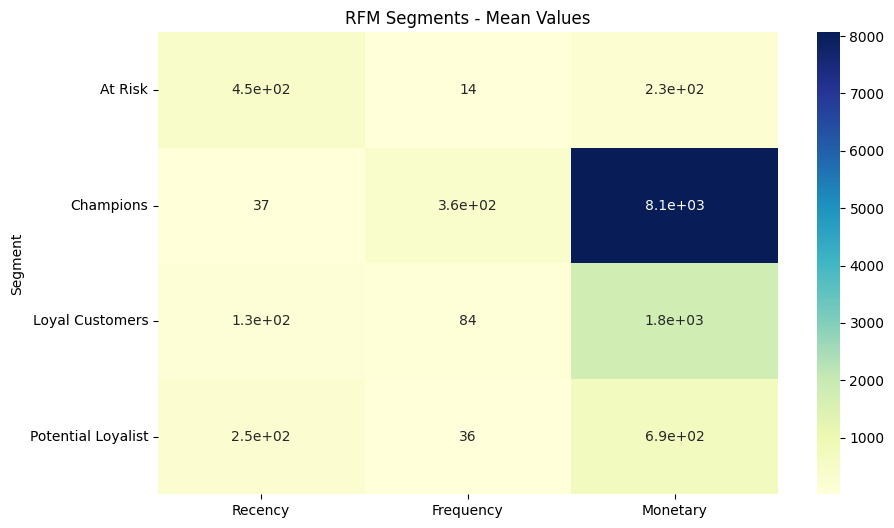

In [32]:
# HeatMap

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(rfm.groupby("Segment")[["Recency","Frequency","Monetary"]].mean(), annot=True, cmap="YlGnBu")
plt.title("RFM Segments - Mean Values")
plt.show()


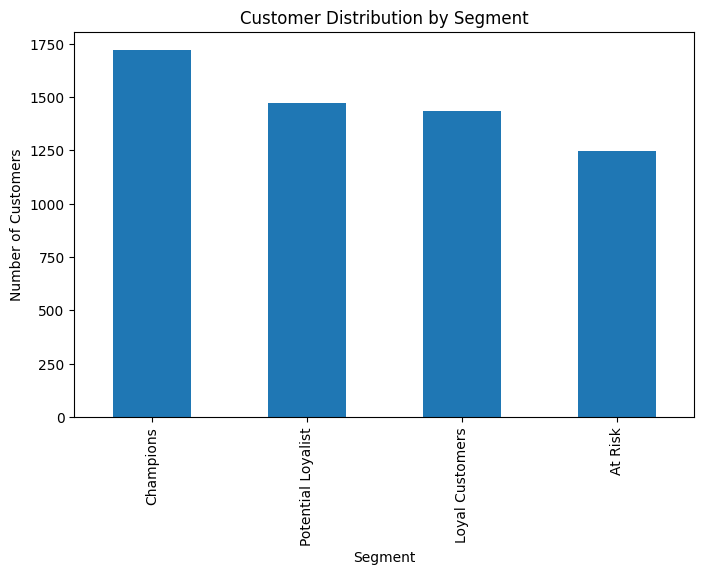

In [33]:
# Bar Chart

rfm["Segment"].value_counts().plot(kind="bar", figsize=(8,5))
plt.title("Customer Distribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.show()


**Marketing Strategies**



*   Champions (High R, F, M) → VIP loyalty program, early access premium offers.
*   Loyal Customers → Reward with discounts, referral incentives.
*   Potential Loyalists → Targeted promotions to increase purchase frequency.
*   At Risk → Win-back campaigns, personalized discounts, reminder emails.
*   Lost Customers → Re-engagement with special offers, surveys for feedback.

